In [10]:
#Requirements
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
import shutil
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics

In [2]:
#Access Directory
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/My Drive/Project_B_Supp/mhist_models')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DO NOT RUN THIS TWICE

In [ ]:
#Divide dataset
data_dir = '/content/drive/My Drive/Project_B_Supp/mhist_dataset/images/images/'
train_dir ='/content/drive/My Drive/Project_B_Supp/mhist_dataset/train/'
test_dir =  '/content/drive/My Drive/Project_B_Supp/mhist_dataset/test/'
annotations = '/content/drive/My Drive/Project_B_Supp/mhist_dataset/annotations.csv'

#sort images based on test/train label, and SSA/HP class
with open(annotations) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  line_count = 0
  for row in reader:
    #skip first line because of headers (filename, class, majority, train/test)
      if line_count == 0:
          line_count += 1
      else:
        #put images in correct directories based on row (train or test)
          if(row[3] == 'train'):
            source = data_dir + row[0]
            dest = train_dir + row[1]+'/'+row[0]
          else:
            source = data_dir + row[0]
            dest = test_dir + row[1]+'/'+row[0]
          
          #copy file to correct locations
          os.makedirs(os.path.dirname(dest), exist_ok=True)
          shutil.copy(source,dest)

Found 2175 files belonging to 2 classes.
Found 977 files belonging to 2 classes.


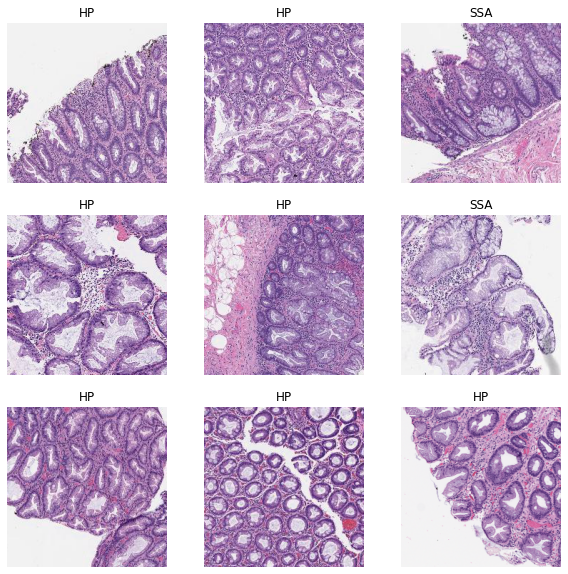

In [3]:
train_dir ='/content/drive/My Drive/Project_B_Supp/mhist_dataset/train/'
test_dir =  '/content/drive/My Drive/Project_B_Supp/mhist_dataset/test/'
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(224,224))
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 image_size=(224,224))
#show images for validation
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

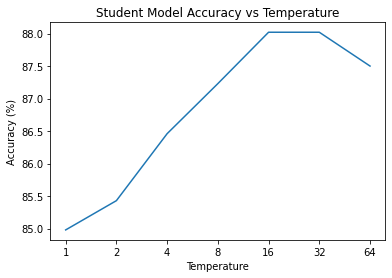

In [4]:
#task 6
# your code start from here for step 6
import matplotlib.pyplot as plt
#Values obtained through iterations of running code with different variables
student_class_accuracy = [84.98, 85.43, 86.46, 87.23, 88.02, 88.02, 87.50]
temperature = [1,2,4,8,16,32,64]

#Accuracy vs Temperature plot
plt.title('Student Model Accuracy vs Temperature')
plt.plot(student_class_accuracy)
plt.ylabel('Accuracy (%)')
plt.xticks([0,1,2,3,4,5,6], temperature)
plt.xlabel('Temperature')
plt.show()

In [6]:
# Evaluate performance of every model
#load teacher
teacher_model = tf.keras.models.load_model('teacher_model',compile=False)
#load student with KD
student_KD_model = tf.keras.models.load_model('student_KD_model',compile=False)
#load student without KD
student_scratch_model = tf.keras.models.load_model('student_without_KD_model',compile=False)

In [71]:
#Evaluate performance
teacher_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
teacher_model.evaluate(validation_dataset)

student_KD_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
student_KD_model.evaluate(validation_dataset)

student_scratch_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])
student_scratch_model.evaluate(validation_dataset)




31/31 [==============================] - 4s 79ms/step - loss: 0.3882 - accuracy: 0.8475 - auc_5: 0.9166


[0.388169527053833, 0.8474923372268677, 0.916576623916626]

In [8]:
#flops
# your code start from here for step 8
#Reference: tokusumi, keras-flops, (2020), Github Repository
!pip install keras-flops
from keras_flops import get_flops

teacher_flops = get_flops(teacher_model, batch_size=1)
studentKD_flops = get_flops(student_KD_model, batch_size=1)
studentwithoutKD_flops = get_flops(student_scratch_model, batch_size=1)
print(f"TEACHER FLOPS: {teacher_flops / 10 ** 9:.04} G")
print(f"STUDENT WITH KD FLOPS: {studentKD_flops / 10 ** 6:.04} M")
print(f"STUDENT WITHOUT KD FLOPS: {studentwithoutKD_flops / 10 ** 6:.04} M")

TEACHER FLOPS: 6.989 G
STUDENT WITH KD FLOPS: 613.0 M
STUDENT WITHOUT KD FLOPS: 613.0 M
